In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import nnls
from scipy.optimize import minimize
from random import choices, choice, randrange, randint
import time
import matplotlib. pyplot as plt

In [2]:
def deconvo(A, b , solv):
    
    ## Perform deconvolution method on sc and bulk data by 3 different methods 
    # Define bounds for minimze solvers
    bounds = []
    for i in range(len(A.columns)):
        bounds.append([0., None])
        
    start_time = time.time()
    
    ## NNLS method
    if solv == "nnls":
        x, fn_val = nnls(A,b)
        # Applaying sum-to-one and converting to prct:
        x = x/np.sum(x) * 100
    
    
    ## Minimize methods
    elif solv == "SLSQP" or solv == "trust-constr": 
        # Use nnls to get initial guess
        x0, rnorm = nnls(A,b)
        # Define minimisation function
        def fn(x, A, b):
            return np.linalg.norm(A.dot(x) - b)

        # Define constraints and bounds
        cons = {'type': 'eq', 'fun': lambda x:  np.sum(x)-1}
        
        # Call minimisation subject to these values
        if solv == "trust-constr":
            minout = minimize(fn, x0, args=(A, b), method='trust-constr',bounds=bounds,constraints=cons)
        else:
            minout = minimize(fn, x0, args=(A, b), method='SLSQP',bounds=bounds,constraints=cons)
    
        # Estimate proportion
        x = minout.x
        
        # Error value between model and observed value
        fn_val = fn(x, A, b)
    else:
        raise ValueError("Unkown solver")  
    
    endtime = time.time()
    elapsed_time = (endtime - start_time)
    
    return x, elapsed_time, fn_val

In [3]:
def rand_bulk(meta, raw_sc_data, kcell, rand_index = None):
    
    ## Simulate a bulk dataset from sc data
    # Random selection of kcell index
    if rand_index == None:
        rand_index = choices(range(len(meta.iloc[:, 0])), k = kcell)
    
    
    # Obtention of selected cell names
    rand_cells = meta.iloc[rand_index,0]
    
    # Subsetting of the kcell cells
    rand_expr = raw_sc_data.loc[:,rand_cells]
    
    # Suming values
    sum_rand_expr = rand_expr.sum(axis=1)
    
    # Rematching with gene names 
    gene_names = raw_sc_data.iloc[:, 0]
    simu_bulk = pd.concat([gene_names, sum_rand_expr], axis=1)
    
    ## Calculating true prop
    # Obtention of selected cell clusters
    rand_clust = meta.iloc[rand_index,7]
    # Summing values
    clust_sum = rand_clust.value_counts()
    # Obtaining proportions
    clust_true_prop = (clust_sum/kcell) * 100

    return simu_bulk, clust_true_prop

In [4]:
def intersect(simu_bulk, sc_avg_data):
    ## Adjusting sc_avg_data and simulated bulk
    # separating into gene names and values 
    sc_avg_gene = sc_avg_data.iloc[:, 0]
    sc_avg_expr = sc_avg_data.iloc[:,1:]
    # subsetting simu bulk data
    sub_simu_bulk = simu_bulk[simu_bulk.iloc[:,0].isin(sc_avg_gene)]
    
    return sub_simu_bulk.iloc[:,1], sc_avg_expr

In [5]:
def rand_subset(meta, sc_raw_data, kcell, pops):
    ## Simulate a bulk dataset from a subset of sc data
    
    # Calculating random proportion for each cluster (population) in the selected subset
    parts = len(pops)
    goal = kcell
    prop = []
    
    for i in range(parts - 1):
        selected_numb = randrange(goal)
        prop.append(selected_numb)
        goal = goal - selected_numb 
    prop.append(goal)
    
    # Selecting the number of cells to match proportion
    i = 0
    selected_cells_index = []
    for pop in pops:
        cell_of_pop = meta[meta['seurat_clusters'] == pop].iloc[:, 0]
        selected_cells_index = selected_cells_index + (choices(cell_of_pop.index, k = prop[i]))
        i = i+1

    # Call the simulation on those cell  
    simu_bulk, true_prop = rand_bulk(meta, sc_raw_data, kcell, selected_cells_index)
    return simu_bulk, true_prop

In [6]:
def simu_avg(sc_avg, kcell):
    
    ## Simulate a bulk dataset from sc avg data
    simu_bulk = []
    verif = 0
    
    # Generate random proportion for each clusters
    rand = choices(sc_avg.columns,k = kcell)
    rand = pd.Series(rand)
    
    for elt in rand:
        # Generate an error value in the range (0.5, 1.5)
        error = randint(5,15)/10 - 0.5
        
        # Multiply and add it to the simulated bulk
        current_val = sc_avg[elt] + sc_avg[elt] * error
        
        if verif == 0:
            simu_bulk= current_val
            verif = 1
        else:
            simu_bulk = simu_bulk + current_val
        
    # Compute Proportions
    prop = rand.value_counts()
    true_prop = (prop/kcell) * 100 
    
    return simu_bulk, true_prop

In [7]:
def simu_avg_disp(sc_avg, kcell):
    
    ## Simulate a bulk dataset from sc avg data with disparate proportion
    simu_bulk = []
    tot_prop = []
    n_col = sc_avg.columns
    goal = kcell
    
    # Select the first cluster
    cluster_pool = list(range(len(n_col)))
    rand_clust = choice(cluster_pool)
    cluster_pool.remove(rand_clust)
    rand_clust = str(rand_clust)
    
    # Loop on the number of clusters (n_col) and generate proportion
    for i in range(len(n_col)):
        # Last cluster get the resting proportion
        if len(n_col) - i == 1:
            prop = goal
        else:
            # Generate proportion while leaving enough rest
            prop = randint(1, goal - (len(n_col)-i))
            
            # Select next cluster 
            next_clust = choice(cluster_pool)
            cluster_pool.remove(next_clust)
            next_clust = str(next_clust)
        goal = goal - prop
        
        # Loop to select a cluster (column) and add it to the bulk with error 
        for j in range(prop):
            col = sc_avg[rand_clust]
            # Generate an error value in the range (0.5, 1.5)
            error = randint(50,150)/100 - 1
            
            # Multiply and add it to the simulated bulk
            current_val = col + col * error
            
            tot_prop.append(int(rand_clust))
            if i == 0 and j == 0:
                simu_bulk = current_val
            else:
                simu_bulk = simu_bulk + current_val
        # Get the next cluster
        rand_clust = next_clust

    # Compute Proportions
    tot_prop = pd.Series(tot_prop)
    true_prop = tot_prop.value_counts()/kcell * 100
    
    return simu_bulk, true_prop

Deconvolution example:

In [8]:
single_cell_avg = pd.read_csv('Selected_gene_sc.tsv', sep = '\t')
single_cell_avg

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.323555,0.094705,0.192635,0.577982,0.353719,0.128162,0.032882,0.104255,0.600437,0.131016,0.029491,0.132231,0.017921,0.362637,0.036290,0.015385,0.180328,0.076923,0.304348
1,0.000863,0.003055,0.000000,0.000000,0.001653,0.005059,0.001934,0.000000,0.000000,0.005348,0.000000,0.002755,0.853047,0.000000,0.274194,0.558974,0.032787,0.329670,0.000000
2,0.005177,0.006110,0.001416,0.009174,0.009917,0.008432,0.174081,0.002128,0.008734,0.002674,0.439678,0.002755,0.465950,0.014652,0.411290,0.358974,0.038251,0.153846,0.000000
3,0.153581,0.068228,0.264873,0.397554,0.171901,0.178752,0.166344,0.287234,0.257642,0.697861,0.083110,0.228650,0.111111,0.183150,0.032258,0.071795,0.180328,0.087912,0.130435
4,0.006903,1.009165,0.000000,0.000000,0.004959,0.005059,0.000000,0.000000,0.002183,0.002674,0.000000,0.000000,0.007168,0.000000,0.000000,0.000000,0.038251,0.000000,0.065217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2859,0.993097,0.945010,0.603399,0.749235,0.662810,0.598651,0.843327,0.525532,0.772926,0.548128,1.428954,0.586777,0.544803,0.501832,0.584677,0.707692,0.628415,0.802198,0.782609
2860,0.260569,0.423625,0.120397,0.152905,0.180165,0.139966,0.396518,0.140426,0.213974,0.125668,0.605898,0.195592,0.394265,0.139194,0.334677,0.205128,0.469945,0.164835,0.347826
2861,0.414150,0.120163,0.140227,0.501529,0.198347,0.124789,0.243714,0.306383,0.879913,0.141711,0.233244,0.088154,0.215054,0.461538,0.318548,0.128205,0.229508,0.197802,0.369565
2862,0.053494,0.177189,0.021246,0.079511,0.071074,0.057336,0.334623,0.072340,0.019651,0.136364,0.378016,0.066116,0.136201,0.051282,0.282258,0.076923,0.852459,0.109890,0.043478


In [9]:
bulk = pd.read_csv('Selected_gene_bulk.tsv', sep = '\t')
gene = bulk['id']
bulk_values = bulk.iloc[:,1:]
bulk_values

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X101,X102,X103,X104,X105,X106,X107,X108,X109,X110
0,0.272364,0.428677,0.108904,0.282876,0.443393,0.057185,0.277305,0.142332,0.119310,0.257542,...,0.297698,0.227899,0.058972,0.263744,0.202460,0.269000,0.340271,0.127299,0.322611,0.120151
1,0.651938,1.162660,0.593676,0.925709,1.217457,2.514403,1.598007,0.746156,0.639809,0.927875,...,1.868096,0.907949,2.120641,1.265974,2.091835,0.367555,0.927659,1.486896,0.618150,0.629630
2,0.014840,0.020105,0.031594,0.007659,0.001436,0.009095,0.003830,0.029679,0.008617,0.003351,...,0.012446,0.011010,0.359023,0.006223,0.013882,0.008617,0.006702,0.032073,0.005266,0.006702
3,1.094460,1.051771,0.673025,1.704511,0.238874,0.592189,0.517711,1.271269,0.511656,0.376627,...,0.290039,0.355132,0.717227,0.418105,0.392371,0.585226,0.660914,0.913412,1.101726,1.521344
4,0.251093,0.134916,0.502811,0.120550,1.321674,0.080575,0.194878,0.446596,0.178014,1.098064,...,0.108682,0.073704,0.291068,0.623985,0.090568,0.236727,0.069332,0.147408,0.049344,0.047470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2859,0.291871,0.210932,1.013315,0.321654,0.297828,0.261388,0.401191,0.625088,0.331114,0.351086,...,0.254730,0.332165,0.925368,0.489488,0.287316,0.257884,0.322705,0.389278,0.343378,0.317449
2860,0.021818,0.025455,0.092468,0.021818,0.015584,0.072727,0.021818,0.121039,0.018701,0.017143,...,0.028052,0.011429,0.339221,0.017143,0.012987,0.020260,0.005714,0.058182,0.018701,0.025455
2861,0.084702,0.059421,0.127269,0.057044,0.015774,0.050562,0.047537,0.124244,0.058773,0.029602,...,0.052723,0.031547,0.173509,0.059637,0.058557,0.064823,0.053803,0.103933,0.076707,0.095938
2862,0.036061,0.021267,0.052011,0.023347,0.010402,0.021960,0.020342,0.081600,0.022654,0.014101,...,0.031438,0.018724,0.522191,0.033287,0.033518,0.032825,0.027739,0.044152,0.018955,0.023810


In [10]:
est_proportion, elapsed_time, est_errror = deconvo(single_cell_avg, bulk_values.iloc[:,1], "nnls")
est_proportion

array([ 0.        ,  1.72159989,  3.16120273,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , 89.9991992 ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  5.11799817,  0.        ,  0.        ])

Simulation example 1 (from averaged single-cell data):

In [12]:
simulated_bulk, true_proportion = simu_avg(single_cell_avg, 1000)
#OR simulated_bulk, true_proportion = simu_avg_disp(single_cell, 1000)

In [15]:
est_proportion, elapsed_time, est_errror = deconvo(single_cell_avg, simulated_bulk, "nnls")
est_proportion

array([5.33520299, 5.44871795, 5.12152778, 4.56063034, 5.21501068,
       4.02644231, 5.06143162, 3.65918803, 6.05635684, 7.26495726,
       5.19497863, 5.5221688 , 5.78926282, 5.12820513, 5.50213675,
       3.9730235 , 5.22836538, 6.06971154, 5.84268162])

In [18]:
true_proportion

9     7.0
17    6.3
8     6.0
12    5.7
18    5.7
1     5.5
11    5.4
14    5.4
0     5.3
16    5.3
4     5.3
10    5.2
13    5.2
2     5.0
6     5.0
3     4.7
15    4.2
5     4.1
7     3.7
dtype: float64

Simulation example 2 (from raw single-cell data):

In [19]:
meta = pd.read_csv('dataset/meta_data_h2', sep = '\t')
meta

,Unnamed: 0,orig.ident,nCount_RNA,nFeature_RNA,nCount_SCT,nFeature_SCT,SCT_snn_res.0.8,seurat_clusters
0,human2_lib1.final_cell_0001,human2,9323,2267,5641,2044,5,5
1,human2_lib1.final_cell_0002,human2,6732,1632,5399,1627,5,5
2,human2_lib1.final_cell_0003,human2,10762,2815,5738,2357,0,0
3,human2_lib1.final_cell_0004,human2,8546,2366,5611,2264,5,5
4,human2_lib1.final_cell_0005,human2,8651,2331,5607,2204,5,5
...,...,...,...,...,...,...,...,...
1719,human2_lib3.final_cell_0561,human2,1571,933,3696,1073,7,7
1720,human2_lib3.final_cell_0562,human2,1703,827,3891,936,10,10
1721,human2_lib3.final_cell_0563,human2,1447,859,3639,1031,6,6
1722,human2_lib3.final_cell_0564,human2,1514,800,3734,955,10,10


In [20]:
sc_raw = pd.read_csv('dataset/treated_h2_data', sep = '\t')
full_gene = sc_raw['Unnamed: 0']
sc_raw

,Unnamed: 0,human2_lib1.final_cell_0001,human2_lib1.final_cell_0002,human2_lib1.final_cell_0003,human2_lib1.final_cell_0004,human2_lib1.final_cell_0005,human2_lib1.final_cell_0006,human2_lib1.final_cell_0007,human2_lib1.final_cell_0008,human2_lib1.final_cell_0009,...,human2_lib3.final_cell_0556,human2_lib3.final_cell_0557,human2_lib3.final_cell_0558,human2_lib3.final_cell_0559,human2_lib3.final_cell_0560,human2_lib3.final_cell_0561,human2_lib3.final_cell_0562,human2_lib3.final_cell_0563,human2_lib3.final_cell_0564,human2_lib3.final_cell_0565
0,A1BG,0.000000,0.000000,0.000000,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,1.098612,0.0,0.000000,0.000000,0.0,0.000000,0.0
1,A1CF,0.000000,1.098612,0.693147,0.000000,0.000000,0.000000,0.693147,0.693147,0.000000,...,0.0,0.0,1.098612,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0
2,A2M,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,1.098612,0.000000,0.0,0.000000,0.0
3,A4GALT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1.098612,0.0
4,AAAS,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14192,ZYG11B,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0
14193,ZYX,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.609438,...,0.0,0.0,0.000000,1.098612,0.0,0.000000,1.098612,0.0,1.098612,0.0
14194,ZZEF1,0.000000,0.000000,0.000000,0.000000,0.000000,0.693147,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,1.098612,0.000000,0.0,0.000000,0.0
14195,ZZZ3,0.000000,1.098612,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0


In [21]:
single_cell_avg2 = pd.read_csv('dataset/selected_genes_sc_h2', sep = '\t')
single_cell_avg2

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12
0,A1CF,0.625430,0.567944,0.110553,0.110465,0.061069,0.496063,0.068627,0.020202,0.322222,0.000000,0.359375,0.380952,0.000000
1,A2M,0.003436,0.000000,0.005025,0.005814,0.000000,0.000000,0.029412,1.393939,0.000000,0.026316,0.125000,0.000000,0.869565
2,A4GALT,0.006873,0.013937,0.000000,0.005814,0.152672,0.000000,0.039216,0.575758,0.000000,0.026316,0.125000,0.000000,0.521739
3,AACS,0.422680,0.414634,0.653266,0.767442,0.236641,0.212598,0.196078,0.191919,0.300000,0.078947,0.421875,0.174603,0.043478
4,ABCA3,0.219931,0.317073,0.547739,0.831395,0.129771,0.259843,0.088235,0.020202,0.233333,0.184211,0.093750,0.365079,0.130435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2568,ZNF787,0.120275,0.167247,0.145729,0.116279,0.312977,0.228346,0.568627,0.383838,0.122222,0.592105,0.156250,0.206349,0.347826
2569,ZNF90,0.553265,0.564460,0.683417,0.703488,0.610687,0.629921,0.686275,1.121212,0.811111,1.486842,0.828125,0.698413,1.043478
2570,ZNFX1,0.113402,0.160279,0.185930,0.220930,0.633588,0.133858,0.362745,0.454545,0.222222,0.276316,0.171875,0.126984,0.521739
2571,ZSWIM4,0.079038,0.087108,0.115578,0.261628,0.541985,0.173228,1.274510,0.252525,0.033333,0.328947,0.140625,0.031746,0.173913


In [22]:
simu_bulk_2, true_prop2 = rand_bulk(meta,sc_raw, 1000)
#OR simu_bulk_2, true_prop2 = rand_bulk(meta,sc_raw, 1000, [0,5])
simu_bulk_2

,Unnamed: 0,0
0,A1BG,4.158883
1,A1CF,175.840814
2,A2M,55.235571
3,A4GALT,37.261177
4,AAAS,106.173816
...,...,...
14192,ZYG11B,156.691916
14193,ZYX,261.730140
14194,ZZEF1,116.359174
14195,ZZZ3,61.180402


In [23]:
simu_bulk, sc_data = intersect(simu_bulk_2, single_cell_avg2)

In [24]:
est_proportion2, elapsed_time2, est_errror2 = deconvo(sc_data, simu_bulk, 'nnls')

In [25]:
est_proportion2

array([ 0.        ,  1.68026151,  0.        , 12.20307489, 29.11873158,
        0.        ,  0.54256209,  3.3348438 ,  0.96692101, 22.76449302,
        5.31324868,  0.        , 24.0758634 ])

To produce figures:

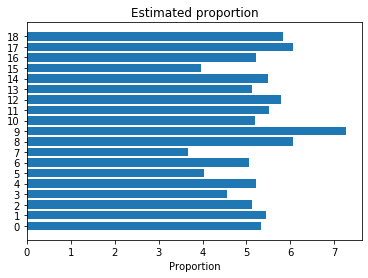

In [27]:
fig, ax = plt.subplots()
y_pos = np.arange(len(est_proportion))
ax.barh(y_pos, est_proportion)
ax.set_yticks(y_pos)
ax.set_xlabel('Proportion')
ax.set_title('Estimated proportion')
# To print it:
plt.show()
# To save it use this instead:
#plt.savefig('filename.png')